In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(cmn, display_labels=estimator.classes_).plot()
  return y_pred

In [ ]:
def xtab(rows_data, cols_data, normalize_rows=False):
  xtab = pd.crosstab(rows_data, cols_data)
  if normalize_rows:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / (rows_data == i).sum()
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

1

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/wildlife0901.csv', sep=';')
dataset.head()

,AC_CLASS,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,DAMAGE,BIRDS_STRUCK,SIZE,WARNED
0,A,1,1.0,9,2011,0,0,1,N,1,Small,N
1,A,1,1.0,5,2013,0,0,1,S,1,Large,N
2,A,1,1.0,9,2013,0,0,1,N,1,Small,Y
3,A,1,1.0,12,2013,0,0,1,N,1,Small,N
4,B,1,1.0,7,2010,0,0,1,N,1,Medium,Y


2

In [ ]:
dataset.AC_CLASS.value_counts().rename({
    'A': 'Airplane',
    'B': 'Helicopter'
})

Airplane      15617
Helicopter      482
Name: AC_CLASS, dtype: int64

3

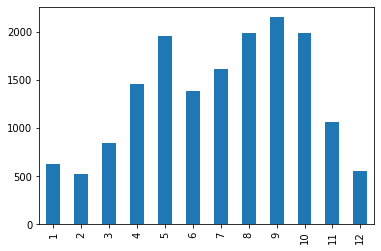

In [ ]:
dataset.INCIDENT_MONTH.value_counts().sort_index().plot(kind='bar')

4

INCIDENT_YEAR   2010  2011  2012  2013  2014
INCIDENT_MONTH                              
1                141   131   142   128    80
2                 79    90   143    95   112
3                177   163   199   147   156
4                245   293   350   297   267
5                309   340   443   426   432
6                248   271   319   269   279
7                404   360   446   401     0
8                514   449   484   537     0
9                505   560   562   525     0
10               411   489   541   546     0
11               270   273   232   290     0
12               122   142   147   141     0


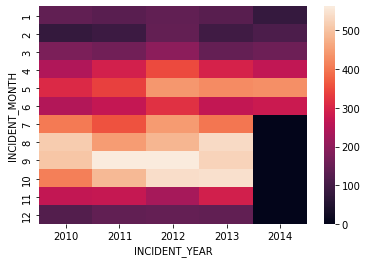

In [ ]:
_ = xtab(dataset.INCIDENT_MONTH, dataset.INCIDENT_YEAR)

La frequenza degli incidenti aumenta nei mesi caldi (7-10) e viceversa cala nei mesi freddi (12-3). Per il 2014 sono disponibili solo i primi sei mesi, ma i dati seguono l'andamento degli anni precedenti.

# Parte 2: Trasformazione e Predizione

1

In [ ]:
damage = {
    'U': 0,
    'N': 1,
    'M': 3,
    'M?':5,
    'S': 7,
    'D': 9,
}

size = {
    'Small': 1,
    'Medium':3,
    'Large': 5,
    'Unknown': 0,
}

warned = {
    'N': 0,
    'Y': 1,
    'Unknown': 3,
    'n': 0,
    'y': 1,
}

replace = {
    'DAMAGE': damage,
    'SIZE': size,
    'WARNED': warned,
}

In [ ]:
dataset1 = dataset.replace(replace)
dataset1.head()

,AC_CLASS,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,DAMAGE,BIRDS_STRUCK,SIZE,WARNED
0,A,1,1.0,9,2011,0,0,1,1,1,1,0
1,A,1,1.0,5,2013,0,0,1,7,1,5,0
2,A,1,1.0,9,2013,0,0,1,1,1,1,1
3,A,1,1.0,12,2013,0,0,1,1,1,1,0
4,B,1,1.0,7,2010,0,0,1,1,1,3,1


2

In [ ]:
data_air = dataset1[(dataset1.AC_CLASS == 'A') & (dataset1.SIZE != 0)]
data_air.drop(columns='AC_CLASS', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data_air.reset_index(drop=True, inplace=True)

In [ ]:
data_air.head()

,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,DAMAGE,BIRDS_STRUCK,SIZE,WARNED
0,1,1.0,9,2011,0,0,1,1,1,1,0
1,1,1.0,5,2013,0,0,1,7,1,5,0
2,1,1.0,9,2013,0,0,1,1,1,1,1
3,1,1.0,12,2013,0,0,1,1,1,1,0
4,2,2.0,9,2012,0,0,1,1,1,3,3


3

In [ ]:
data_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14842 entries, 0 to 14841
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_MASS         14842 non-null  int64  
 1   NUM_ENGS        14835 non-null  float64
 2   INCIDENT_MONTH  14842 non-null  int64  
 3   INCIDENT_YEAR   14842 non-null  int64  
 4   HEIGHT          14842 non-null  int64  
 5   SPEED           14842 non-null  int64  
 6   PHASE_OF_FLT    14842 non-null  int64  
 7   DAMAGE          14842 non-null  int64  
 8   BIRDS_STRUCK    14842 non-null  int64  
 9   SIZE            14842 non-null  int64  
 10  WARNED          14842 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.2 MB


In [ ]:
data_air.dropna(inplace=True) # axis=0, how='any'
data_air.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_MASS         14835 non-null  int64  
 1   NUM_ENGS        14835 non-null  float64
 2   INCIDENT_MONTH  14835 non-null  int64  
 3   INCIDENT_YEAR   14835 non-null  int64  
 4   HEIGHT          14835 non-null  int64  
 5   SPEED           14835 non-null  int64  
 6   PHASE_OF_FLT    14835 non-null  int64  
 7   DAMAGE          14835 non-null  int64  
 8   BIRDS_STRUCK    14835 non-null  int64  
 9   SIZE            14835 non-null  int64  
 10  WARNED          14835 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.2 MB


4

In [ ]:
train, test = train_test_split(data_air, train_size=.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='SIZE')
y_tr = train.SIZE
X_ts = test.drop(columns='SIZE')
y_ts = test.SIZE

In [ ]:
from sklearn.naive_bayes import BernoulliNB

Accuracy: 0.6832030196818549
Confusion matrix:
 [[2531    0    1]
 [ 880    0    0]
 [ 294    0    3]]


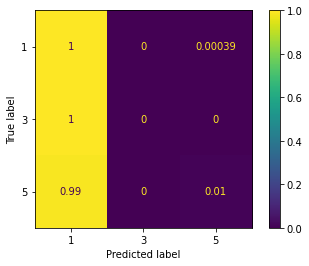

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, BernoulliNB())

L'accuratezza complessiva risulta elevata perchè la classe prevalente viene predetta correttamente, ma le predizioni per le altre due classi sono quasi interamente scorrette, verso la classe prevalente ("biased towards the prevailing class").

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Accuracy: 0.5936910218387705
Confusion matrix:
 [[1898  524  110]
 [ 552  228  100]
 [ 124   97   76]]


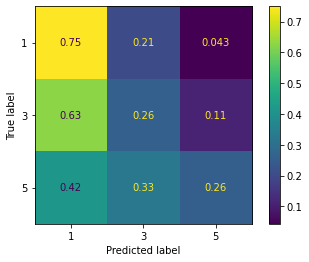

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

L'accuratezza cala e le predizioni per le due classi classi non prevalenti rimangono per lo più scorrette, ma senza uno scostamento così pronunciato come con il classificatore BernoulliNB

In [ ]:
train, test = train_test_split(data_air, train_size=.75, random_state=1,
                               stratify=data_air.SIZE)

In [ ]:
X_tr = train.drop(columns='SIZE')
y_tr = train.SIZE
X_ts = test.drop(columns='SIZE')
y_ts = test.SIZE

Accuracy: 0.6104071178215152
Confusion matrix:
 [[1933  534  121]
 [ 492  246   93]
 [ 120   85   85]]


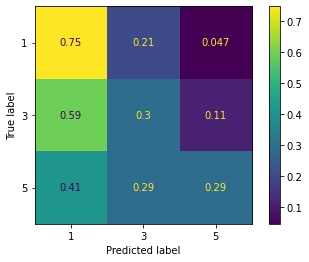

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

L'accuratezza sulle classi 3 e 5 migliora leggermente

8

In [ ]:
dataset2 = dataset.copy()

In [ ]:
dataset2 = dataset2[(dataset2.AC_CLASS == 'A') & (dataset2.SIZE != 0)]
dataset2.drop(columns='AC_CLASS', inplace=True)
dataset2.reset_index(drop=True, inplace=True)
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15617 entries, 0 to 15616
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_MASS         15617 non-null  int64  
 1   NUM_ENGS        15610 non-null  float64
 2   INCIDENT_MONTH  15617 non-null  int64  
 3   INCIDENT_YEAR   15617 non-null  int64  
 4   HEIGHT          15617 non-null  int64  
 5   SPEED           15617 non-null  int64  
 6   PHASE_OF_FLT    15617 non-null  int64  
 7   DAMAGE          15617 non-null  object 
 8   BIRDS_STRUCK    15617 non-null  int64  
 9   SIZE            15617 non-null  object 
 10  WARNED          15617 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 1.3+ MB


In [ ]:
damage = {
    'U': np.nan,
}

size = {
    'Small': 1,
    'Medium':3,
    'Large': 5,
    'Unknown': np.nan,
}

warned = {
    'N': 0,
    'Y': 1,
    'n': 0,
    'y': 1,
    'Unknown': np.nan,
}

replace = {
    'DAMAGE': damage,
    'SIZE'  : size,
    'WARNED': warned,
}

dataset2.replace(replace, inplace=True)
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15617 entries, 0 to 15616
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_MASS         15617 non-null  int64  
 1   NUM_ENGS        15610 non-null  float64
 2   INCIDENT_MONTH  15617 non-null  int64  
 3   INCIDENT_YEAR   15617 non-null  int64  
 4   HEIGHT          15617 non-null  int64  
 5   SPEED           15617 non-null  int64  
 6   PHASE_OF_FLT    15617 non-null  int64  
 7   DAMAGE          15617 non-null  object 
 8   BIRDS_STRUCK    15617 non-null  int64  
 9   SIZE            14842 non-null  float64
 10  WARNED          12549 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.3+ MB


In [ ]:
dataset2.dropna(inplace=True)
dataset2.reset_index(drop=True, inplace=True)

In [ ]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12094 entries, 0 to 12093
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AC_MASS         12094 non-null  int64  
 1   NUM_ENGS        12094 non-null  float64
 2   INCIDENT_MONTH  12094 non-null  int64  
 3   INCIDENT_YEAR   12094 non-null  int64  
 4   HEIGHT          12094 non-null  int64  
 5   SPEED           12094 non-null  int64  
 6   PHASE_OF_FLT    12094 non-null  int64  
 7   DAMAGE          12094 non-null  object 
 8   BIRDS_STRUCK    12094 non-null  int64  
 9   SIZE            12094 non-null  float64
 10  WARNED          12094 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.0+ MB


In [ ]:
dataset2 = add_dummies(dataset2, 'DAMAGE')
dataset2.head()

,AC_MASS,NUM_ENGS,INCIDENT_MONTH,INCIDENT_YEAR,HEIGHT,SPEED,PHASE_OF_FLT,BIRDS_STRUCK,SIZE,WARNED,N,S,M,M?,D
0,1,1.0,9,2011,0,0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1.0,5,2013,0,0,1,1,5.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,1.0,9,2013,0,0,1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1,1.0,12,2013,0,0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,2.0,9,2011,0,0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
train, test = train_test_split(dataset2, train_size=.75, random_state=1,
                               stratify=dataset2.SIZE)

In [ ]:
X_tr = train.drop(columns='SIZE')
y_tr = train.SIZE
X_ts = test.drop(columns='SIZE')
y_ts = test.SIZE

Accuracy: 0.6154100529100529
Confusion matrix:
 [[1593  404  112]
 [ 406  197   82]
 [  97   62   71]]


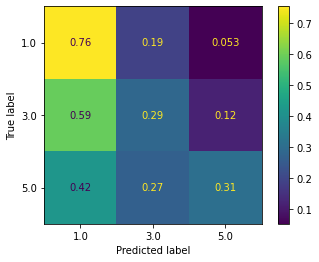

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.7199074074074074
Confusion matrix:
 [[2067    0   42]
 [ 576    0  109]
 [ 120    0  110]]


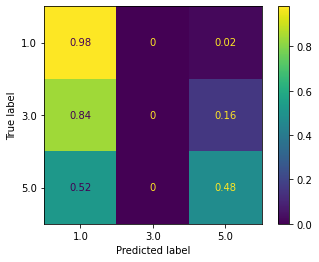

In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, BernoulliNB())

9

In [ ]:
X = data_air.drop(columns='SIZE')
y = data_air.SIZE

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=5,
                n_jobs=-1).mean()

0.4103808560835861